**Aneezah Aslam**
***Blue***

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import re

Loading CSV file


In [2]:
url = "https://docs.google.com/spreadsheets/d/12JWizEwTPYgXOmh_762iy-Q5694zxhlO/export?format=csv"

zameen = pd.read_csv(url , usecols=["City", "Location","Price","Type","Area","Bedrooms","Bathrooms","Servant Quarters","Kitchens","Store Rooms","Built in year", "Description"])

Understanding and Cleaning data

In [3]:
zameen.dtypes

,0
City,object
Type,object
Area,object
Price,object
Location,object
Description,object
Built in year,float64
Bedrooms,object
Bathrooms,object
Servant Quarters,float64


In [4]:
#changing datatype of built in year from float to datetime
zameen['Built in year'] = pd.to_datetime(zameen['Built in year'], format='%Y', errors='coerce')

Converting Area in Square Yard


In [5]:

def area_sqyd(x):
    if pd.isna(x):
        return None

    x = str(x).lower().strip()

    match = re.match(r'(\d+\.?\d*)\s*(.*)', x)
    if not match:
        return None

    value = float(match.group(1))
    unit = match.group(2)

    if "marla" in unit:
        return value * 30.25
    elif "kanal" in unit:
        return value * 605
    elif "yd" in unit:
        return value
    else:
        return None



In [6]:
# converting the area unit into square yards
zameen['Area'] = zameen['Area'].apply(area_sqyd)

Converting price in PKR

In [7]:
def convert_price(x):
    if pd.isna(x):
        return None

    x = str(x).replace("PKR", "").replace("\n", " ").strip().lower()

    if "thousand" in x:
        value = float(x.replace("thousand", "").strip())
        return value * 1_000

    elif "lakh" in x:
        value = float(x.replace("lakh", "").strip())
        return value * 100_000

    elif "crore" in x:
        value = float(x.replace("crore", "").strip())
        return value * 10_000_000

    elif "arab" in x:
        value = float(x.replace("arab", "").strip())
        return value * 1_000_000_000

    else:
        return float(x)



In [8]:
# converting price into PKR with no units
zameen["Price"] = zameen["Price"].apply(convert_price)

Missing Values Treatment

Bedrooms using mode


In [9]:
zameen["Bedrooms"].isna().sum()

np.int64(16)

In [10]:
zameen["Bedrooms"].mode()

,Bedrooms
0,5


In [11]:
zameen['Bedrooms'] = zameen['Bedrooms'].fillna(zameen['Bedrooms'].mode()[0])

Bathrooms using mode




In [12]:
zameen["Bathrooms"].isna().sum()

np.int64(16)

In [13]:
zameen["Bathrooms"].mode()

,Bathrooms
0,6


In [14]:
zameen['Bathrooms'] = zameen['Bathrooms'].fillna(zameen['Bathrooms'].mode()[0])

Servant Quarters using mode

In [15]:
zameen["Servant Quarters"].isna().sum()

np.int64(8598)

In [16]:
zameen["Servant Quarters"].mode()

,Servant Quarters
0,1.0


In [17]:
zameen['Servant Quarters'] = zameen['Servant Quarters'].fillna(zameen['Servant Quarters'].mode()[0])

Kitchens using mode

In [18]:
zameen["Kitchens"].isna().sum()

np.int64(4999)

In [19]:
zameen["Kitchens"].mode()

,Kitchens
0,2.0


In [20]:
zameen['Kitchens'] = zameen['Kitchens'].fillna(zameen['Kitchens'].mode()[0])

Store Rooms using mode

In [21]:
zameen["Store Rooms"].isna().sum()

np.int64(8536)

In [22]:
zameen["Store Rooms"].mode()

,Store Rooms
0,1.0


In [23]:
zameen['Store Rooms'] = zameen['Store Rooms'].fillna(zameen['Store Rooms'].mode()[0])

Built in year using median


In [24]:
zameen["Built in year"].isna().sum()

np.int64(6845)

In [25]:
zameen["Built in year"].median()

Timestamp('2024-01-01 00:00:00')

In [26]:
zameen["Built in year"] = zameen["Built in year"].fillna(zameen["Built in year"].median())

Area using median

In [27]:
zameen["Area"].isna().sum()

np.int64(16)

In [28]:
zameen['Area'] = zameen.groupby('Type')['Area'].transform(lambda x: x.fillna(x.mean()))
zameen['Area'] = zameen['Area'].fillna(zameen['Area'].median())

Price using median


In [29]:
zameen["Price"].isna().sum()

np.int64(16)

In [30]:
zameen['Price'] = zameen.groupby('Type')['Price'].transform(lambda x: x.fillna(x.mean()))
zameen['Price'] = zameen['Price'].fillna(zameen['Price'].median())

Not available Location by unknown

In [31]:
zameen["Location"].isna().sum()

np.int64(16)

In [32]:
zameen['Location'] = zameen['Location'].fillna('Unknown')

Not available Description to unknown

In [33]:
zameen["Description"].isna().sum()

np.int64(3362)

In [34]:
zameen['Description'] = zameen['Description'].fillna('Unknown')

Data Cleaning & Consistency

Fuzzy Wuzzy

In [35]:
!pip install fuzzywuzzy python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 51.3 MB/s eta 0:00:00


In [36]:
from fuzzywuzzy import process

In [37]:
standard_cities = ['Karachi', 'Islamabad', 'Faisalabad', 'Multan', 'Rawalpindi',
       'Peshawar', 'Jhelum', 'Murree', 'Hyderabad', 'Bahawalpur',
       'Sialkot', 'Abbottabad', 'Sahiwal', 'Lahore', 'Gujrat', 'Wah Cantt.',
       'Sargodha', 'Sheikhupura', 'Chakwal', 'Naran', 'Nowshera',
       'Mardan', 'Chilas', 'Sarai Alamgir', 'Quetta', 'Rahim Yar Khan',
       'Okara', 'Attock', 'Dera Ghazi Khan', 'Taxila', 'Sukkur', 'Gawadar',
       'Kasur', 'Mirpur', 'Haripur', 'Gujar Khan', 'Gharo', 'Mirpur Khas',
       'Swat', 'Daska', 'Sadiqabad', 'Buner', 'Jhang', 'Lalamusa',
       'Lodhran', 'Pakpattan', 'Chiniot', 'Dera Ismail Khan',
       'Fateh Jang', 'Burewala', 'Hafizabad', 'Talagang', 'Vehari',
       'Jamshoro', 'Galyat', 'Gujranwala', 'Kharian']

In [38]:
def standardize_city(city):
    if pd.isna(city):
        return city
    best_match = process.extractOne(city, standard_cities)
    if best_match[1] >= 80:
        return best_match[0]
    else:
        return city

In [39]:
# standardizing the city column
zameen["City"] = zameen["City"].apply(standardize_city)

Inconsistent property type


In [40]:
zameen['Type'].isna().sum()

np.int64(16)

In [41]:
# filled nan with other
zameen["Type"]=zameen['Type'].fillna('Other')

In [42]:
zameen["Type"].unique()

array(['Flat', 'House', 'Upper Portion', 'Lower Portion', 'Penthouse',
       'Farm House', 'Other', 'Room'], dtype=object)

Dealing with Outliers

In [43]:
zameen.dtypes

,0
City,object
Type,object
Area,float64
Price,float64
Location,object
Description,object
Built in year,datetime64[ns]
Bedrooms,object
Bathrooms,object
Servant Quarters,float64


In [44]:
numerical_cols = zameen.select_dtypes(include=['float64', 'int64']).columns

In [45]:
# checking skewness in data
zameen[numerical_cols].skew()

,0
Area,49.981560
Price,10.258760
Servant Quarters,11.934638
Kitchens,98.189345
Store Rooms,11.646721


Removing outliers using IQR method

In [46]:
numerical_cols = ['Area', 'Price', 'Servant Quarters', 'Kitchens', 'Store Rooms']

In [47]:
for col in numerical_cols:
    Q1 = zameen[col].quantile(0.25)
    Q3 = zameen[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    zameen = zameen[(zameen[col] >= lower_bound) & (zameen[col] <= upper_bound)]

In [48]:
zameen[numerical_cols].skew()

,0
Area,1.134411
Price,1.067097
Servant Quarters,0.000000
Kitchens,-0.516592
Store Rooms,0.000000


Feature Engineering

Price per Area

In [49]:
zameen['Price_per_Area'] = zameen['Price'] / zameen['Area']

Location Detail

In [50]:
zameen['Location_Granular'] = zameen['Location'].str.split(',').str[0]

In [51]:
zameen['Location_Granular'] = zameen['Location'].fillna('Unknown').str.split(',').str[0]

Total Rooms

In [52]:
convert_dtype = ['Bedrooms', 'Bathrooms', 'Servant Quarters', 'Store Rooms']

In [53]:
zameen[convert_dtype] = zameen[convert_dtype].apply(pd.to_numeric, errors='coerce')

In [54]:
zameen['Total_Rooms'] = (zameen['Bedrooms'] + zameen['Bathrooms'] + zameen['Servant Quarters'] + zameen['Store Rooms'])

Univariate & Bivariate Analysis

Histograms

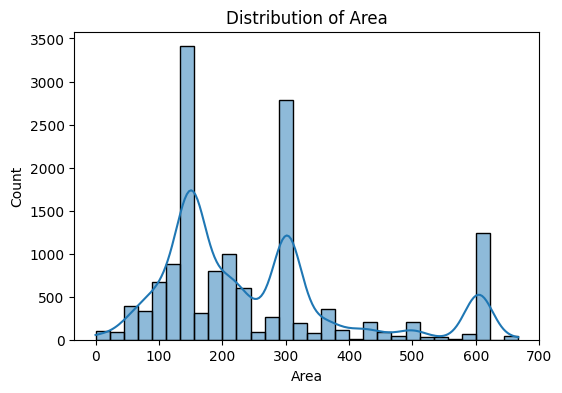

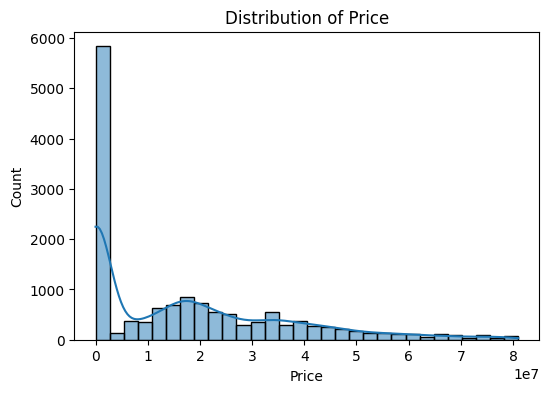

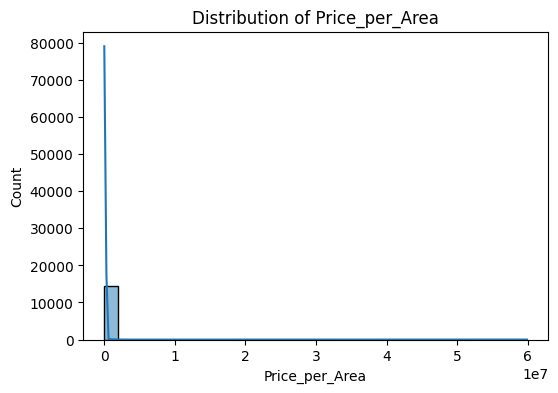

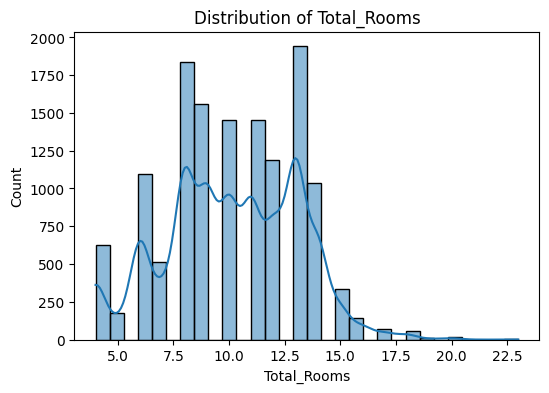

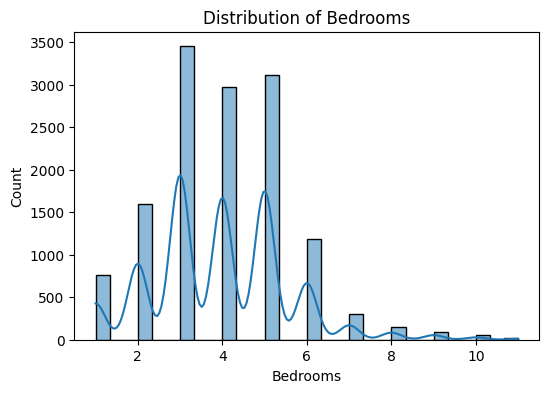

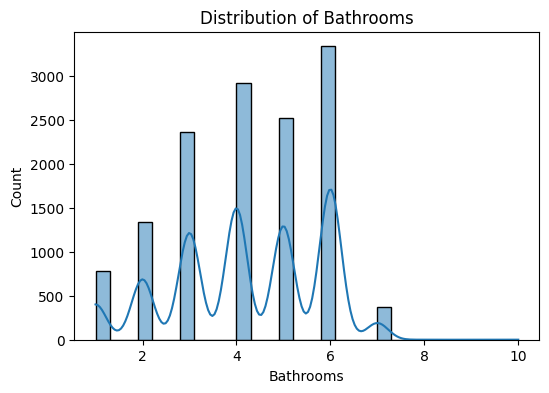

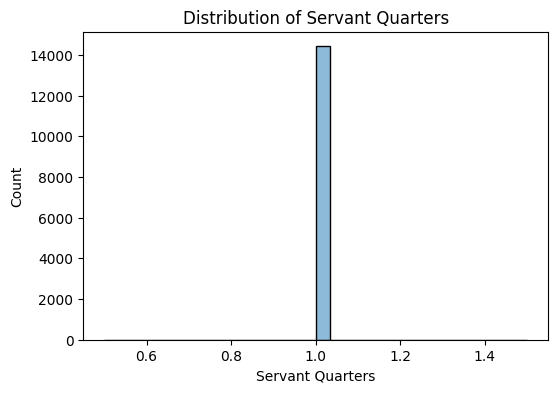

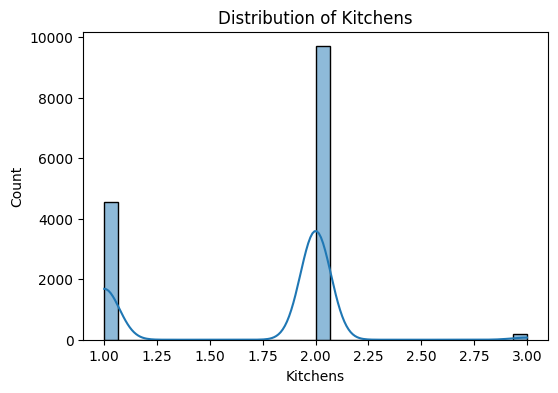

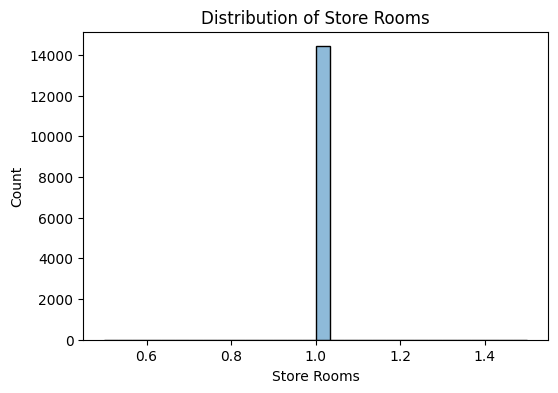

In [55]:
numerical_cols = ['Area', 'Price', 'Price_per_Area', 'Total_Rooms', 'Bedrooms', 'Bathrooms', 'Servant Quarters', 'Kitchens', 'Store Rooms']

for col in numerical_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(zameen[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

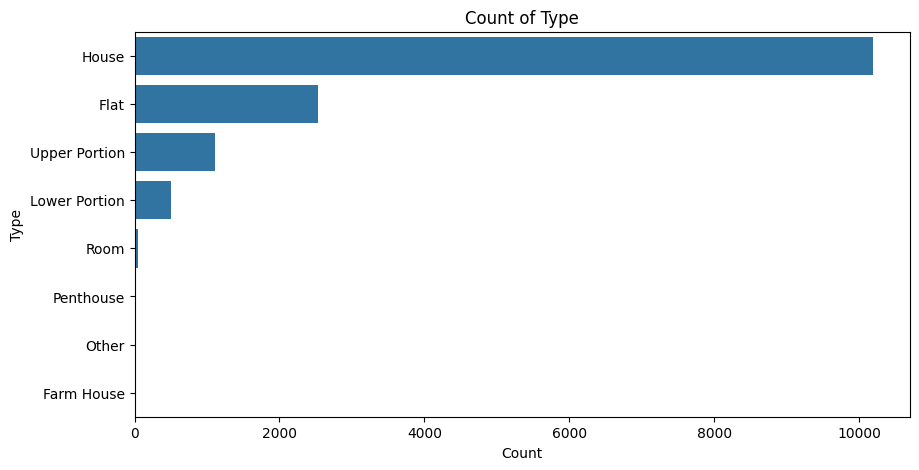

In [56]:
categorical_cols = ['Type']

for col in categorical_cols:
    plt.figure(figsize=(10,5))
    sns.countplot(data=zameen, y=col, order=zameen[col].value_counts().index)
    plt.title(f'Count of {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.show()

Bar charts

/tmp/ipython-input-2120480901.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_price_type, x='Type', y='Price', palette='viridis')


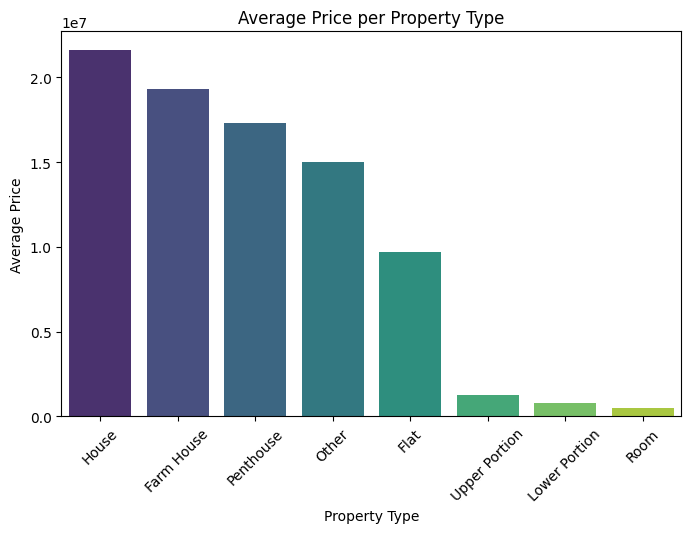

In [57]:
avg_price_type = zameen.groupby('Type')['Price'].mean().reset_index()
avg_price_type = avg_price_type.sort_values(by='Price', ascending=False)


plt.figure(figsize=(8,5))
sns.barplot(data=avg_price_type, x='Type', y='Price', palette='viridis')
plt.title('Average Price per Property Type')
plt.xticks(rotation=45)
plt.ylabel('Average Price')
plt.xlabel('Property Type')
plt.show()


/tmp/ipython-input-335823950.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_locations, x='Price', y='Location_Granular', palette='coolwarm')


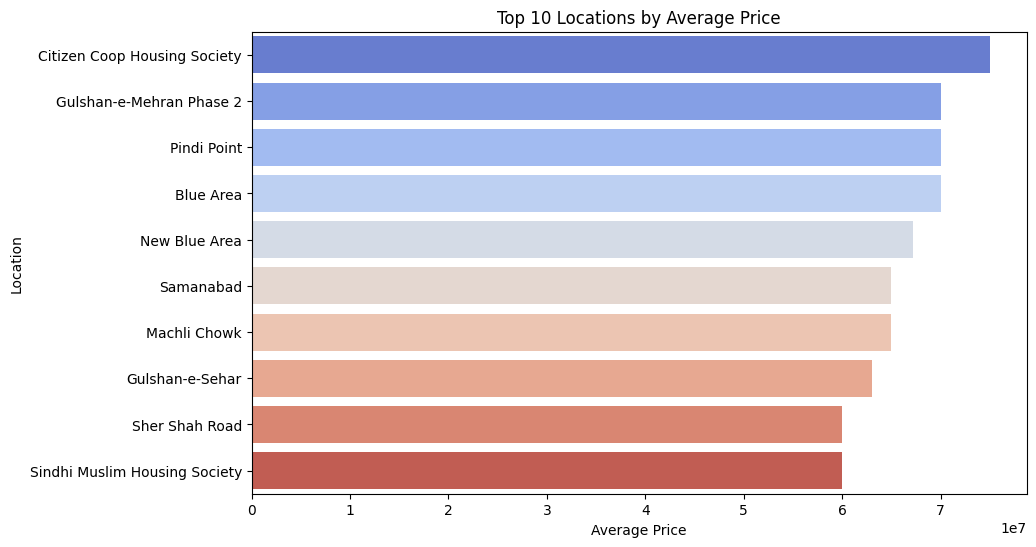

In [58]:
avg_price_location = zameen.groupby('Location_Granular')['Price'].mean().reset_index()


top_locations = avg_price_location.sort_values(by='Price', ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(data=top_locations, x='Price', y='Location_Granular', palette='coolwarm')
plt.title('Top 10 Locations by Average Price')
plt.xlabel('Average Price')
plt.ylabel('Location')
plt.show()



/tmp/ipython-input-1473650155.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=property_count, x='Type', y='Count', palette='Set2')


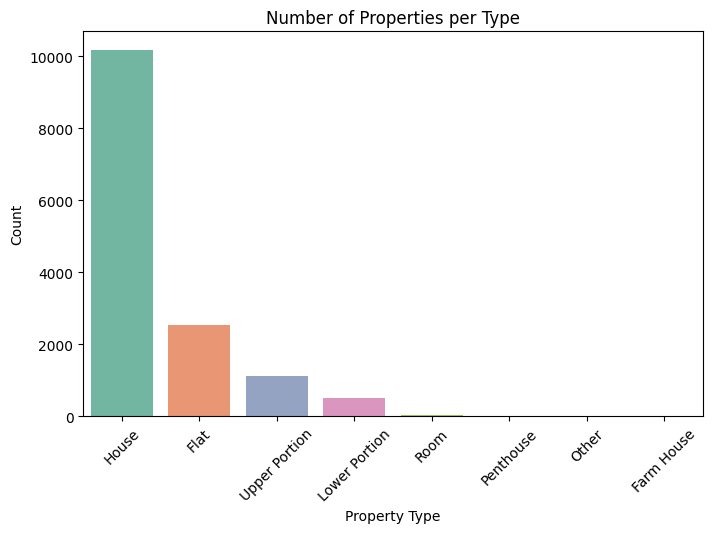

In [59]:
property_count = zameen['Type'].value_counts().reset_index()
property_count.columns = ['Type', 'Count']

plt.figure(figsize=(8,5))
sns.barplot(data=property_count, x='Type', y='Count', palette='Set2')
plt.title('Number of Properties per Type')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.xlabel('Property Type')
plt.show()


Correlation Heatmap

In [60]:
cols = ['Area', 'Price', 'Price_per_Area', 'Total_Rooms','Bedrooms', 'Bathrooms', 'Servant Quarters', 'Kitchens', 'Store Rooms']


In [61]:
corr_matrix = zameen[cols].corr()
print(corr_matrix)


                      Area     Price  Price_per_Area  Total_Rooms  Bedrooms  \
Area              1.000000  0.195089       -0.061338     0.394685  0.370304   
Price             0.195089  1.000000        0.112619     0.455680  0.432967   
Price_per_Area   -0.061338  0.112619        1.000000     0.040730  0.039934   
Total_Rooms       0.394685  0.455680        0.040730     1.000000  0.967680   
Bedrooms          0.370304  0.432967        0.039934     0.967680  1.000000   
Bathrooms         0.399081  0.454915        0.039254     0.967796  0.873034   
Servant Quarters       NaN       NaN             NaN          NaN       NaN   
Kitchens          0.040563  0.244878        0.011468     0.375476  0.353453   
Store Rooms            NaN       NaN             NaN          NaN       NaN   

                  Bathrooms  Servant Quarters  Kitchens  Store Rooms  
Area               0.399081               NaN  0.040563          NaN  
Price              0.454915               NaN  0.244878          Na

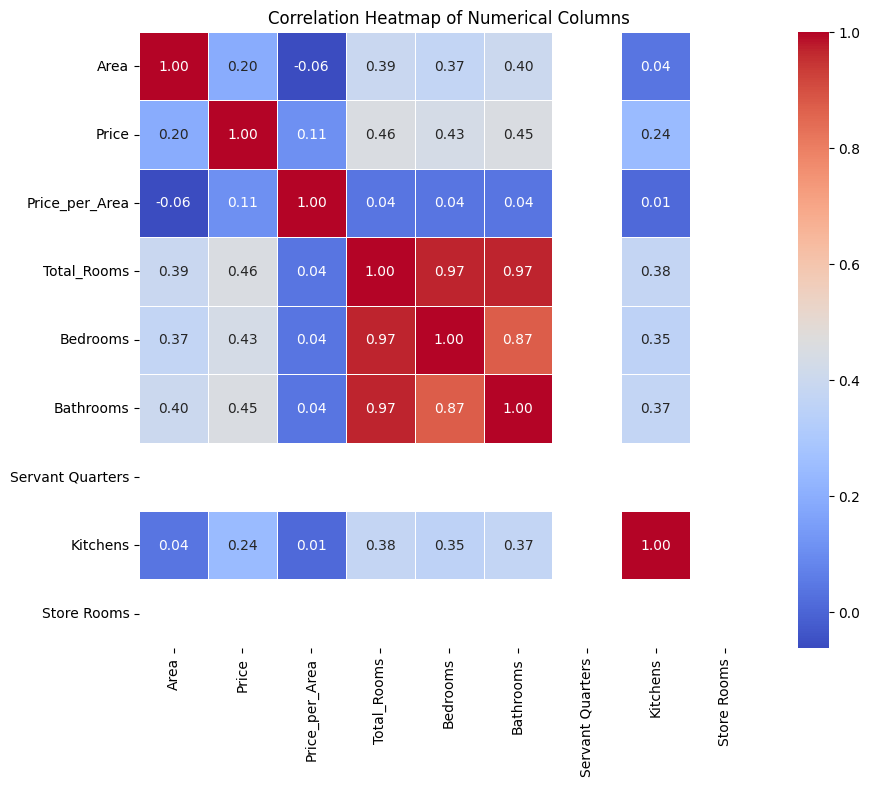

In [62]:
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Columns')
plt.show()


Violin plots / box plots

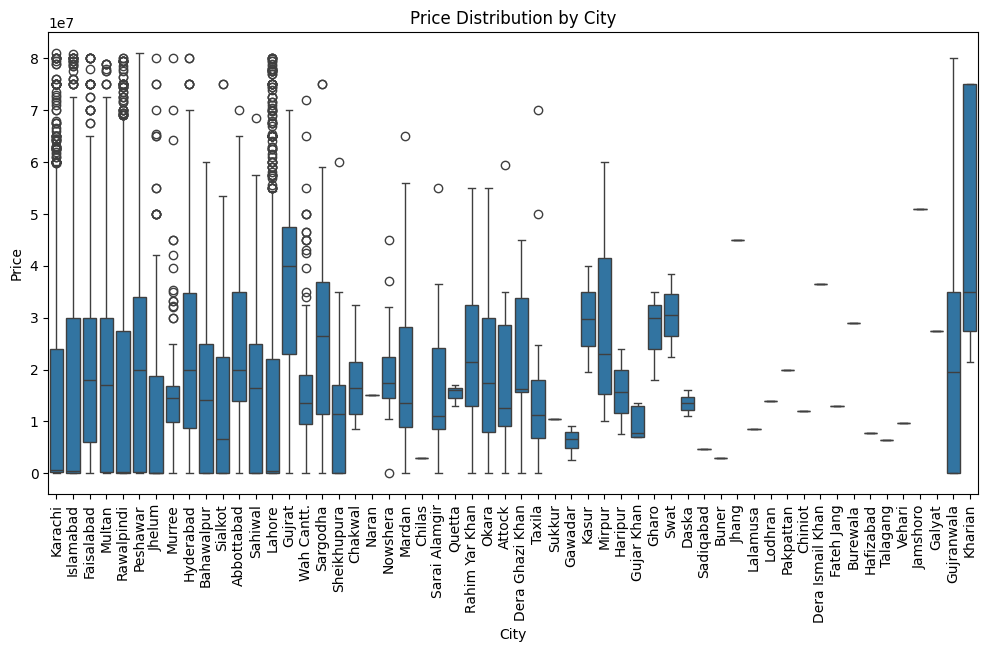

In [63]:
plt.figure(figsize=(12,6))
sns.boxplot(data=zameen, x='City', y='Price')
plt.title('Price Distribution by City')
plt.xticks(rotation=90)
plt.ylabel('Price')
plt.xlabel('City')
plt.show()


/tmp/ipython-input-1452223798.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=zameen, x='Type', y='Price', palette='Set2')


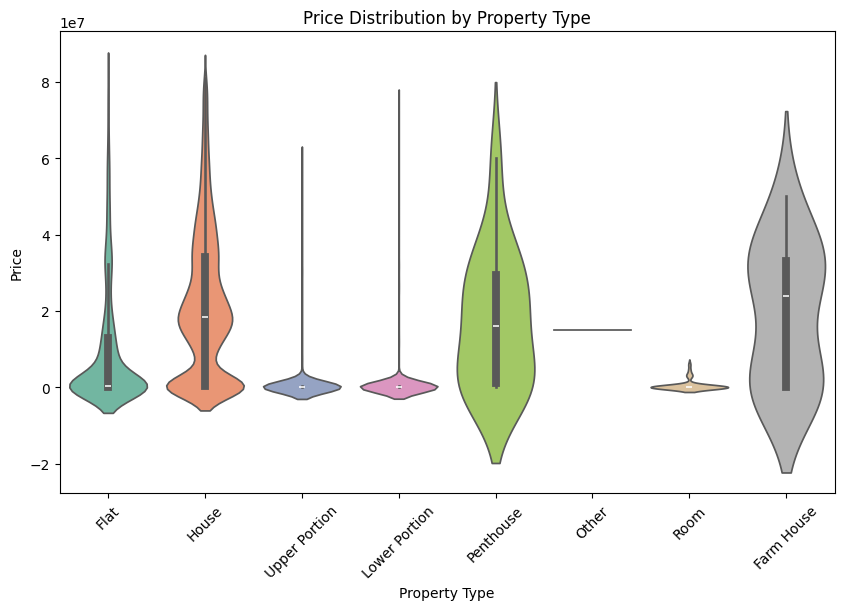

In [64]:
plt.figure(figsize=(10,6))
sns.violinplot(data=zameen, x='Type', y='Price', palette='Set2')
plt.title('Price Distribution by Property Type')
plt.xticks(rotation=45)
plt.ylabel('Price')
plt.xlabel('Property Type')
plt.show()


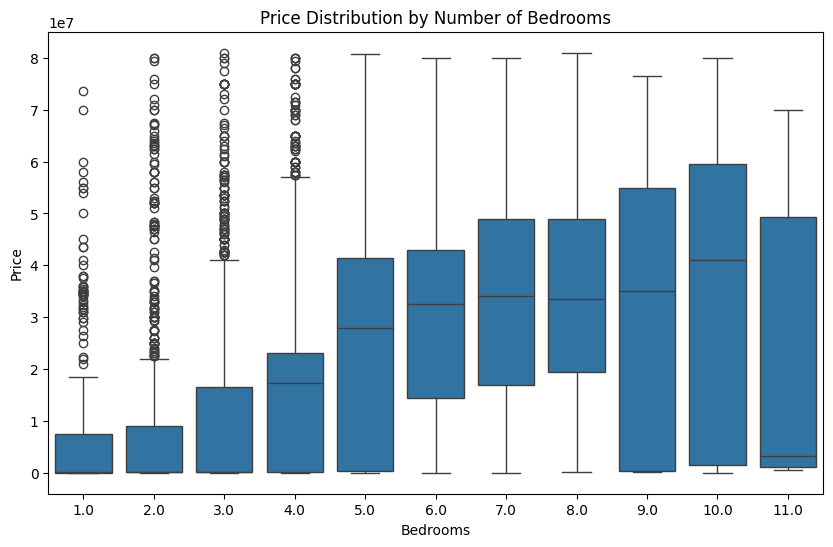

In [65]:
plt.figure(figsize=(10,6))
sns.boxplot(data=zameen, x='Bedrooms', y='Price')
plt.title('Price Distribution by Number of Bedrooms')
plt.ylabel('Price')
plt.xlabel('Bedrooms')
plt.show()
